In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Function to augment images
def augment_images(image_paths, labels):
    datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2,
                                 height_shift_range=0.2, shear_range=0.2,
                                 zoom_range=0.2, horizontal_flip=True,
                                 fill_mode='nearest')
    augmented_images = []
    augmented_labels = []
    for img_path, label in zip(image_paths, labels):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        for _ in range(5):  # Generate 5 augmented images per original
            aug_img = datagen.flow(img, batch_size=1)[0]
            augmented_images.append(aug_img[0])
            augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)


In [3]:
# Function to extract features using ResNet50
def extract_features(images):
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 459ms/step
Train set class distribution: [375 375]
Test set class distribution: [125 125]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       125
           1       0.96      0.97      0.96       125

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250

Confusion Matrix:
 [[120   5]
 [  4 121]]


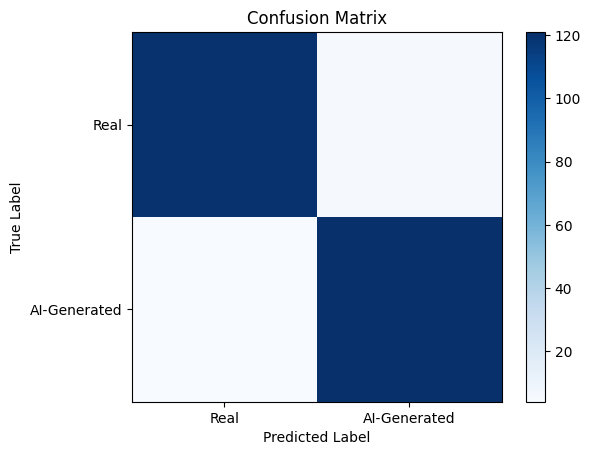

Cross-Validation Scores: [0.915 0.855 0.91  0.885 0.955]
Average Cross-Validation Accuracy: 0.90
Original Dataset Size: 200
Real Images: 100 AI Images: 100
Augmented Dataset Size: 1000


In [4]:
# Main script
if __name__ == "__main__":
    # Set up paths to image folders (real and AI-generated)
    real_image_folder = "datasets/real"  # Folder containing real images
    ai_image_folder = "datasets/fake"  # Folder containing AI-generated images

    # Collect all image paths and labels
    real_images = [os.path.join(real_image_folder, f) for f in os.listdir(real_image_folder)]
    ai_images = [os.path.join(ai_image_folder, f) for f in os.listdir(ai_image_folder)]
    image_paths = real_images + ai_images
    labels = [0] * len(real_images) + [1] * len(ai_images)

    # Augment data
    augmented_images, augmented_labels = augment_images(image_paths, labels)

    # Extract features
    features = extract_features(augmented_images)

    # Train-test split (Stratified)
    X_train, X_test, y_train, y_test = train_test_split(features, augmented_labels, 
                                                        test_size=0.25, stratify=augmented_labels, random_state=42)

    # Debugging: Check class distribution
    print("Train set class distribution:", np.bincount(y_train))
    print("Test set class distribution:", np.bincount(y_test))

    # Train Logistic Regression
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(2), ['Real', 'AI-Generated'])
    plt.yticks(np.arange(2), ['Real', 'AI-Generated'])
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Cross-Validation
    skf = StratifiedKFold(n_splits=5)
    cross_val_scores = cross_val_score(clf, features, augmented_labels, cv=skf, scoring='accuracy')
    print(f"Cross-Validation Scores: {cross_val_scores}")
    print(f"Average Cross-Validation Accuracy: {np.mean(cross_val_scores):.2f}")

    # Debugging: Check original and augmented dataset sizes
print("Original Dataset Size:", len(image_paths))
print("Real Images:", len(real_images), "AI Images:", len(ai_images))
print("Augmented Dataset Size:", len(augmented_images))



In [5]:
from skimage.feature import local_binary_pattern
import numpy as np

# Function to extract color histograms
def extract_color_histogram(image, bins=(8, 8, 8)):
    """Calculate the color histogram of an image."""
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Function to extract texture features using Local Binary Patterns
def extract_texture_features(image, num_points=24, radius=3):
    """Calculate texture features using Local Binary Patterns."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, num_points, radius, method='uniform')
    # Calculate histogram of the LBP features
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum()  # Normalize
    return lbp_hist

# Extract color histograms and texture features
color_histograms = []
texture_features = []

for img_path in image_paths:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))  # Resize to maintain consistency
    color_histograms.append(extract_color_histogram(img))
    texture_features.append(extract_texture_features(img))

# Convert lists to numpy arrays for compatibility with machine learning models
color_histograms = np.array(color_histograms)
texture_features = np.array(texture_features)

# Example output: Shape of extracted features
print(f"Color Histograms Shape: {color_histograms.shape}")
print(f"Texture Features Shape: {texture_features.shape}")


Color Histograms Shape: (9, 512)
Texture Features Shape: (9, 26)


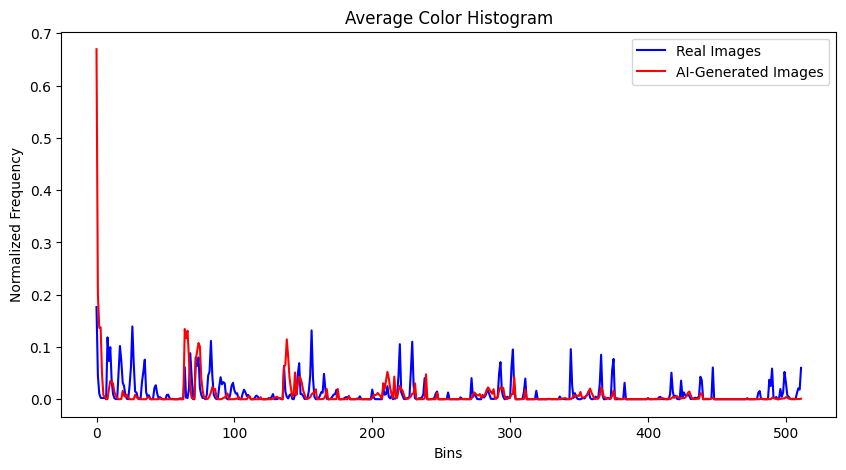

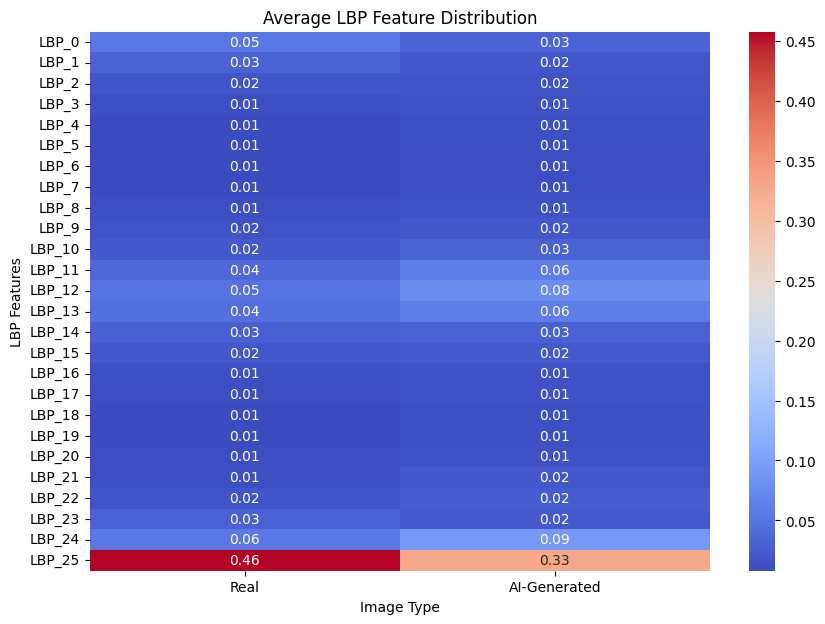

                 Feature  Real Images  AI-Generated Images
0  Color Histograms Mean     0.011025             0.008814
1   Color Histograms Std     0.042797             0.043306
2  Texture Features Mean     0.038462             0.038462
3   Texture Features Std     0.088023             0.063200


In [6]:
import pandas as pd
import seaborn as sns

# Visualize Color Histogram Averages
def visualize_color_histograms(color_histograms, labels):
    """Plot average color histograms for real and AI-generated images."""
    avg_real = np.mean(color_histograms[np.array(labels) == 0], axis=0)
    avg_ai = np.mean(color_histograms[np.array(labels) == 1], axis=0)

    plt.figure(figsize=(10, 5))
    plt.plot(avg_real, label='Real Images', color='blue')
    plt.plot(avg_ai, label='AI-Generated Images', color='red')
    plt.title("Average Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.show()

# Visualize Texture Feature Distribution
def visualize_texture_features(texture_features, labels):
    """Plot a heatmap of texture feature distributions."""
    texture_df = pd.DataFrame(texture_features, columns=[f"LBP_{i}" for i in range(texture_features.shape[1])])
    texture_df['Label'] = labels

    # Calculate averages for each class
    avg_features = texture_df.groupby('Label').mean().T
    avg_features.columns = ['Real', 'AI-Generated']

    # Plot heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(avg_features, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Average LBP Feature Distribution")
    plt.ylabel("LBP Features")
    plt.xlabel("Image Type")
    plt.show()

# Generate a Table of Feature Statistics
def generate_feature_statistics(color_histograms, texture_features, labels):
    """Create a summary table of feature statistics."""
    stats = {
        "Feature": ["Color Histograms Mean", "Color Histograms Std", "Texture Features Mean", "Texture Features Std"],
        "Real Images": [
            np.mean(color_histograms[np.array(labels) == 0]),
            np.std(color_histograms[np.array(labels) == 0]),
            np.mean(texture_features[np.array(labels) == 0]),
            np.std(texture_features[np.array(labels) == 0]),
        ],
        "AI-Generated Images": [
            np.mean(color_histograms[np.array(labels) == 1]),
            np.std(color_histograms[np.array(labels) == 1]),
            np.mean(texture_features[np.array(labels) == 1]),
            np.std(texture_features[np.array(labels) == 1]),
        ],
    }
    stats_df = pd.DataFrame(stats)
    print(stats_df)
    return stats_df

# Visualize Color Histograms
visualize_color_histograms(color_histograms, labels)

# Visualize Texture Features
visualize_texture_features(texture_features, labels)

# Generate and Display Feature Statistics Table
feature_stats = generate_feature_statistics(color_histograms, texture_features, labels)
